In [10]:
!pip install ta

In [11]:
!pip install arcticdb

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

In [13]:
class MomentumIndicatorPipeline:
    def __init__(self, lib_name='momentum_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_rsi(self, df, window=14):
        rsi = RSIIndicator(close=df['Close'], window=window)
        df[f'rsi_{window}'] = rsi.rsi()
        return df

    def compute_stochastic(self, df, window=14, smooth_window=3):
        stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=window, smooth_window=smooth_window)
        df[f'stoch_k_{window}'] = stoch.stoch()
        df[f'stoch_d_{window}'] = stoch.stoch_signal()
        return df

    def compute_macd(self, df, fast=12, slow=26, signal=9):
        macd = MACD(close=df['Close'], window_fast=fast, window_slow=slow, window_sign=signal)
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        df['macd_diff'] = macd.macd_diff()  # Histogram
        return df

    def plot_indicators(self, df):
        # RSI
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['rsi_14'], label='RSI 14', color='orange')
        plt.axhline(70, color='red', linestyle='--')
        plt.axhline(30, color='green', linestyle='--')
        plt.title('Relative Strength Index (RSI)')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # Stochastic Oscillator
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['stoch_k_14'], label='%K', color='blue')
        plt.plot(df.index, df['stoch_d_14'], label='%D', color='magenta')
        plt.axhline(80, color='red', linestyle='--')
        plt.axhline(20, color='green', linestyle='--')
        plt.title('Stochastic Oscillator')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # MACD
        plt.figure(figsize=(14, 5))
        plt.plot(df.index, df['macd'], label='MACD', color='blue')
        plt.plot(df.index, df['macd_signal'], label='Signal', color='red')
        plt.bar(df.index, df['macd_diff'], label='Histogram', color='gray', alpha=0.4)
        plt.title('MACD')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, rsi_windows=[14], stoch_windows=[14], macd_params=(12, 26, 9)):
        df = df.copy()
        for w in rsi_windows:
            df = self.compute_rsi(df, window=w)
        for w in stoch_windows:
            df = self.compute_stochastic(df, window=w)
        df = self.compute_macd(df, *macd_params)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written momentum indicators for {symbol} to ArcticDB")

        # Plot the indicators automatically
        self.plot_indicators(df)

        return df


In [14]:
class TrendIndicatorPipeline:
    def __init__(self, lib_name='trend_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_sma(self, df, window=20):
        df[f'sma_{window}'] = df['Close'].rolling(window=window).mean()
        return df

    def compute_ema(self, df, span=20):
        df[f'ema_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
        return df

    def compute_adx(self, df, window=14):
        adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=window)
        df[f'adx_{window}'] = adx.adx()
        return df

    def plot_indicators(self, df):
        # Plot SMA and EMA
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df.index, df['sma_20'], label='SMA 20')
        plt.plot(df.index, df['ema_20'], label='EMA 20')
        plt.title('Trend Indicators: Close Price, SMA, EMA')
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot ADX
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['adx_14'], label='ADX 14', color='purple')
        plt.axhline(25, color='gray', linestyle='--', label='Trend Threshold')
        plt.title('Average Directional Index (ADX)')
        plt.xlabel('Timestamp')
        plt.ylabel('ADX')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, df: pd.DataFrame, symbol: str, sma_windows=[20], ema_spans=[20], adx_windows=[14]):
        df = df.copy()
        for w in sma_windows:
            df = self.compute_sma(df, window=w)
        for s in ema_spans:
            df = self.compute_ema(df, span=s)
        for a in adx_windows:
            df = self.compute_adx(df, window=a)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written trend indicators for {symbol} to ArcticDB")

        # Plot the indicators automatically
        self.plot_indicators(df)

        return df

In [15]:
from arcticdb import Arctic

ac = Arctic(f"lmdb://{DB_PATH}")

# 使用 get_library 并允许创建
cleaned_lib = ac.get_library('cleaned_data', create_if_missing=True)
engineered_lib = ac.get_library('engineered_data', create_if_missing=True)

trend_lib = ac.get_library('trend_indicators', create_if_missing=True)
momentum_lib = ac.get_library('momentum_indicators', create_if_missing=True)

Mounted at /content/drive
[INFO] Written trend indicators for BTC_sample_1month to ArcticDB


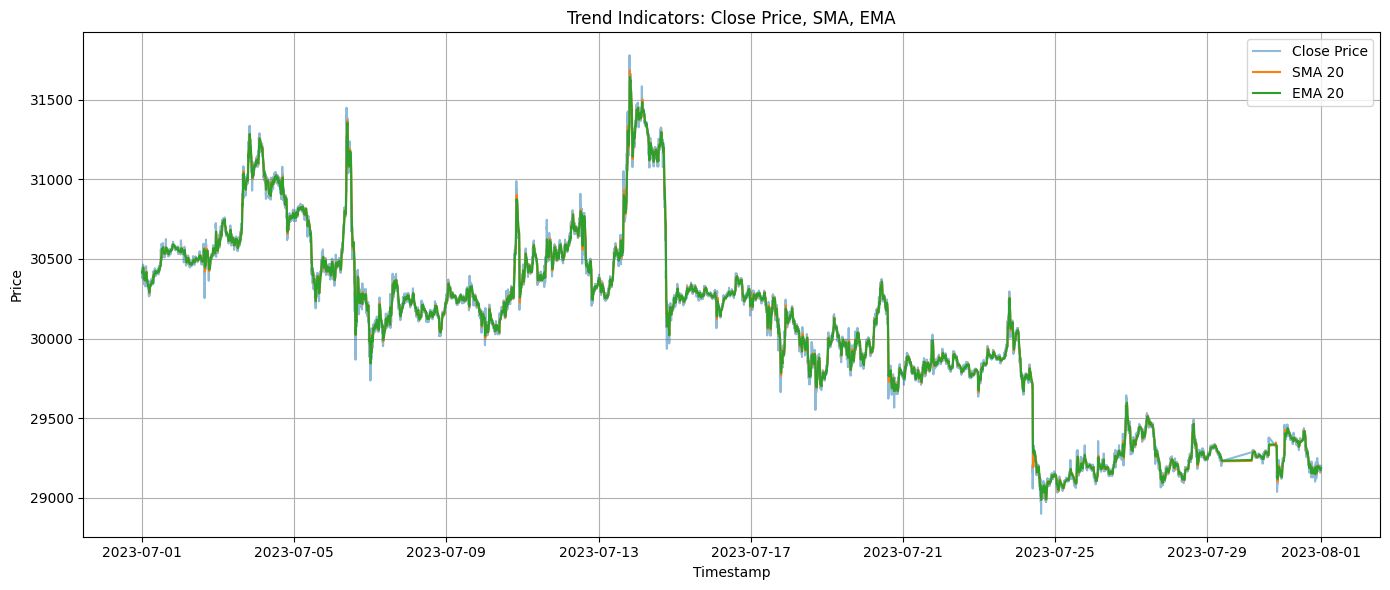

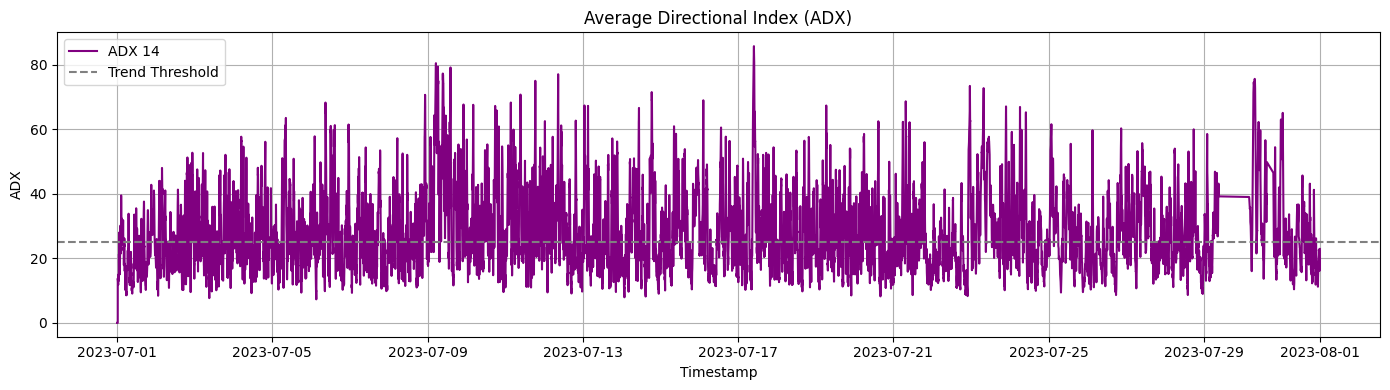

[INFO] Written momentum indicators for BTC_sample_1month to ArcticDB


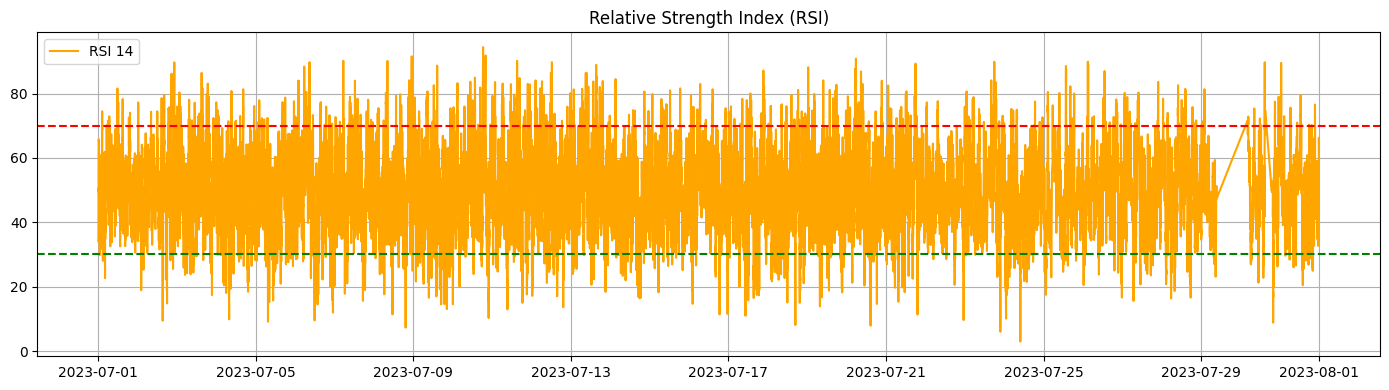

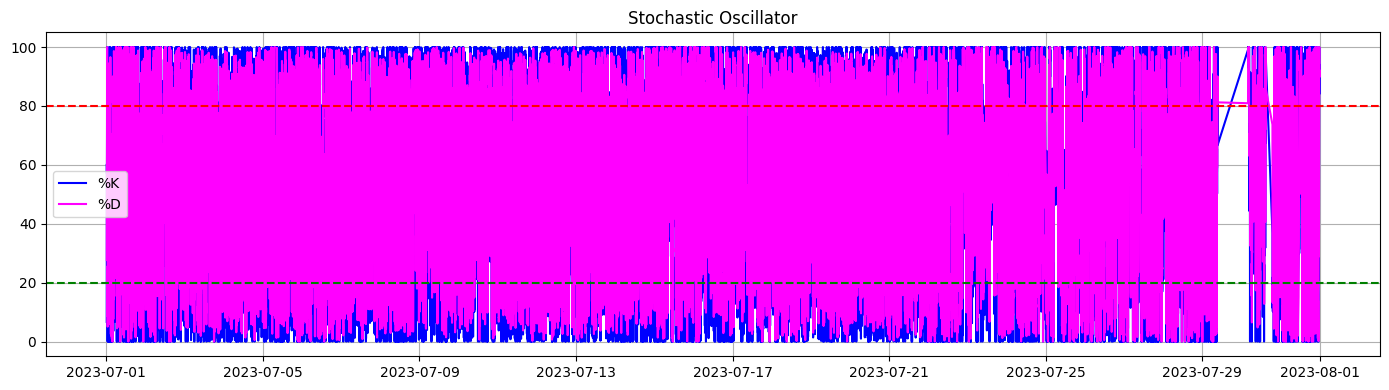

<ipython-input-4-3061476266>:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.legend(); plt.grid(); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


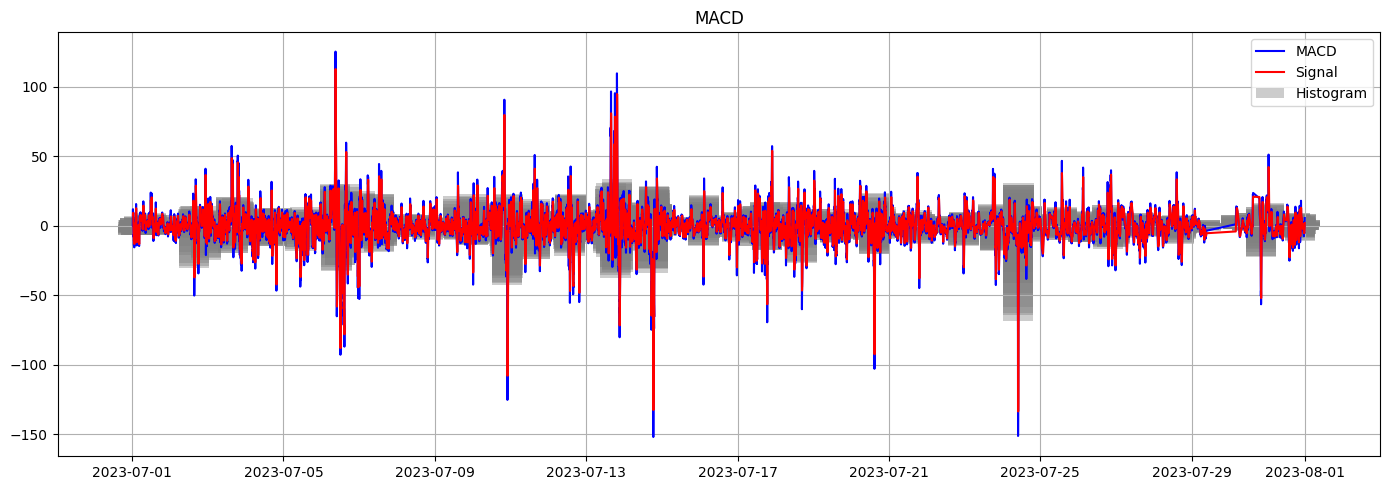

In [9]:
from google.colab import drive
drive.mount('/content/drive')

# 设置数据库和数据文件路径
DB_PATH = '/content/drive/My Drive/Skye_bitcoin/arcticdb_store'  # 存储指标计算结果
csv_file = '/content/drive/My Drive/Skye_bitcoin/raw_sample_2023_07.csv'  # 原始数据

# 如果 arcticdb_store 目录还不存在就创建
import os
os.makedirs(DB_PATH, exist_ok=True)

# 加载数据
import pandas as pd

df = pd.read_csv(csv_file)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# 连接 ArcticDB
from arcticdb import Arctic
ac = Arctic(f"lmdb://{DB_PATH}")

# 初始化四个库（可用于存储不同阶段数据）
cleaned_lib = ac.get_library('cleaned_data', create_if_missing=True)
engineered_lib = ac.get_library('engineered_data', create_if_missing=True)
trend_lib = ac.get_library('trend_indicators', create_if_missing=True)
momentum_lib = ac.get_library('momentum_indicators', create_if_missing=True)

# 运行趋势指标管道
pipeline = TrendIndicatorPipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
df_with_indicators = pipeline.run(df, symbol='BTC_sample_1month')

# 运行动量指标管道
momentum_pipeline = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
df_momentum = momentum_pipeline.run(df, symbol='BTC_sample_1month')

In [16]:
df_trend = trend_lib.read('BTC_sample_1month').data

df_trend.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,sma_20,ema_20,adx_14
Timestamp,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,30416.900000,0.0
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,NaN,30414.642857,0.0
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,NaN,30413.457823,0.0
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,NaN,30413.452316,0.0
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,NaN,30414.342572,0.0


In [17]:
df_momentum = momentum_lib.read('BTC_sample_1month').data

df_momentum.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,rsi_14,stoch_k_14,stoch_d_14,macd,macd_signal,macd_diff
Timestamp,,,,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
"""VolatilityIndicatorPipeline

Extends your existing technical-indicator framework with classic volatility tools:
  • Bollinger Bands (moving average ± k·σ)
  • Average True Range (ATR)

Drop this class into the same notebook or import it as a module.  Usage mirrors the
Trend/Momentum pipelines you already have:

    vip = VolatilityIndicatorPipeline(store_path=f"lmdb://{DB_PATH}")
    df_vol = vip.run(df, symbol="BTC_sample_1month")
"""

from arcticdb import Arctic
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands, AverageTrueRange

class VolatilityIndicatorPipeline:
    """Compute & persist volatility indicators (Bollinger Bands, ATR) and auto-plot.

    Parameters
    ----------
    lib_name : str
        ArcticDB library name to store results (default 'volatility_indicators').
    store_path : str
        Path/URL to the ArcticDB LMDB store.
    """

    def __init__(self, lib_name: str = "volatility_indicators", store_path: str = "arctic_store"):
        # Connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    # ------------------------------------------------------------------
    # Indicator calculators
    # ------------------------------------------------------------------
    @staticmethod
    def compute_bbands(df, window: int = 20, n_std: int = 2):
        """Append Bollinger-Band columns to *df*.

        New columns: bb_mavg_<window>, bb_high_<window>_<n_std>,
                     bb_low_<window>_<n_std>, bb_width_<window>_<n_std>.
        """
        bb = BollingerBands(close=df["Close"], window=window, window_dev=n_std)
        df[f"bb_mavg_{window}"] = bb.bollinger_mavg()
        df[f"bb_high_{window}_{n_std}"] = bb.bollinger_hband()
        df[f"bb_low_{window}_{n_std}"] = bb.bollinger_lband()
        df[f"bb_width_{window}_{n_std}"] = df[f"bb_high_{window}_{n_std}"] - df[f"bb_low_{window}_{n_std}"]
        return df

    @staticmethod
    def compute_atr(df, window: int = 14):
        """Append ATR column: atr_<window>."""
        atr = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=window)
        df[f"atr_{window}"] = atr.average_true_range()
        return df

    # ------------------------------------------------------------------
    # Plot helpers
    # ------------------------------------------------------------------
    def _plot_bbands(self, df, window: int, n_std: int):
        mavg = f"bb_mavg_{window}"
        upper = f"bb_high_{window}_{n_std}"
        lower = f"bb_low_{window}_{n_std}"
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df["Close"], label="Close", alpha=0.5)
        plt.plot(df.index, df[mavg], label=mavg, linewidth=1.2)
        plt.plot(df.index, df[upper], label=upper, linewidth=0.8)
        plt.plot(df.index, df[lower], label=lower, linewidth=0.8)
        plt.fill_between(df.index, df[lower], df[upper], alpha=0.1)
        plt.title("Bollinger Bands")
        plt.xlabel("Timestamp"); plt.ylabel("Price")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    def _plot_atr(self, df, window: int):
        atr_col = f"atr_{window}"
        plt.figure(figsize=(14, 3.8))
        plt.plot(df.index, df[atr_col], label=atr_col, color="orange")
        plt.title("Average True Range")
        plt.xlabel("Timestamp"); plt.ylabel("ATR")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    def plot_indicators(self, df, bb_params, atr_windows):
        for w, n in bb_params:
            self._plot_bbands(df, w, n)
        for w in atr_windows:
            self._plot_atr(df, w)

    # ------------------------------------------------------------------
    # Pipeline driver
    # ------------------------------------------------------------------
    def run(
        self,
        df,
        symbol: str,
        bb_params: list[tuple[int, int]] | None = None,
        atr_windows: list[int] | None = None,
    ):
        """High-level orchestrator similar to your Trend/Momentum pipelines."""
        if bb_params is None:
            bb_params = [(20, 2)]  # (window, n_std)
        if atr_windows is None:
            atr_windows = [14]

        df = df.copy()
        # Compute bands
        for window, n_std in bb_params:
            df = self.compute_bbands(df, window=window, n_std=n_std)
        # Compute ATR
        for window in atr_windows:
            df = self.compute_atr(df, window=window)

        # Persist to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written volatility indicators for {symbol} to ArcticDB")

        # Auto-plot
        self.plot_indicators(df, bb_params, atr_windows)
        return df


[INFO] Written volatility indicators for BTC_sample_1month to ArcticDB


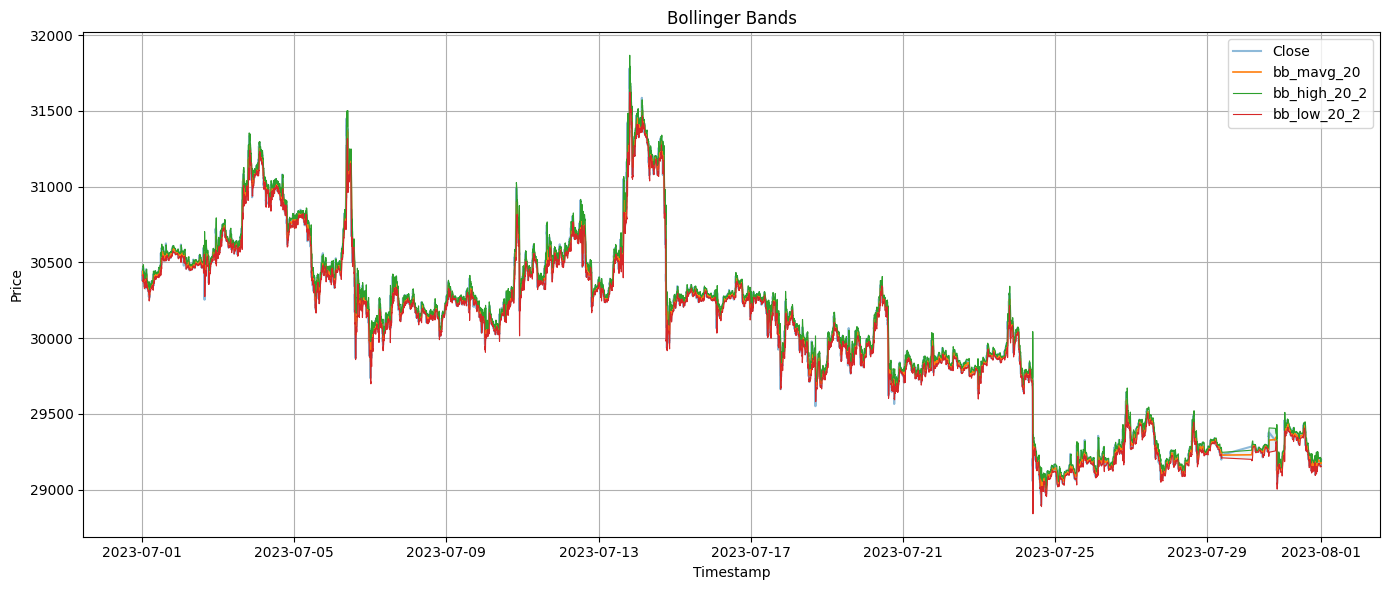

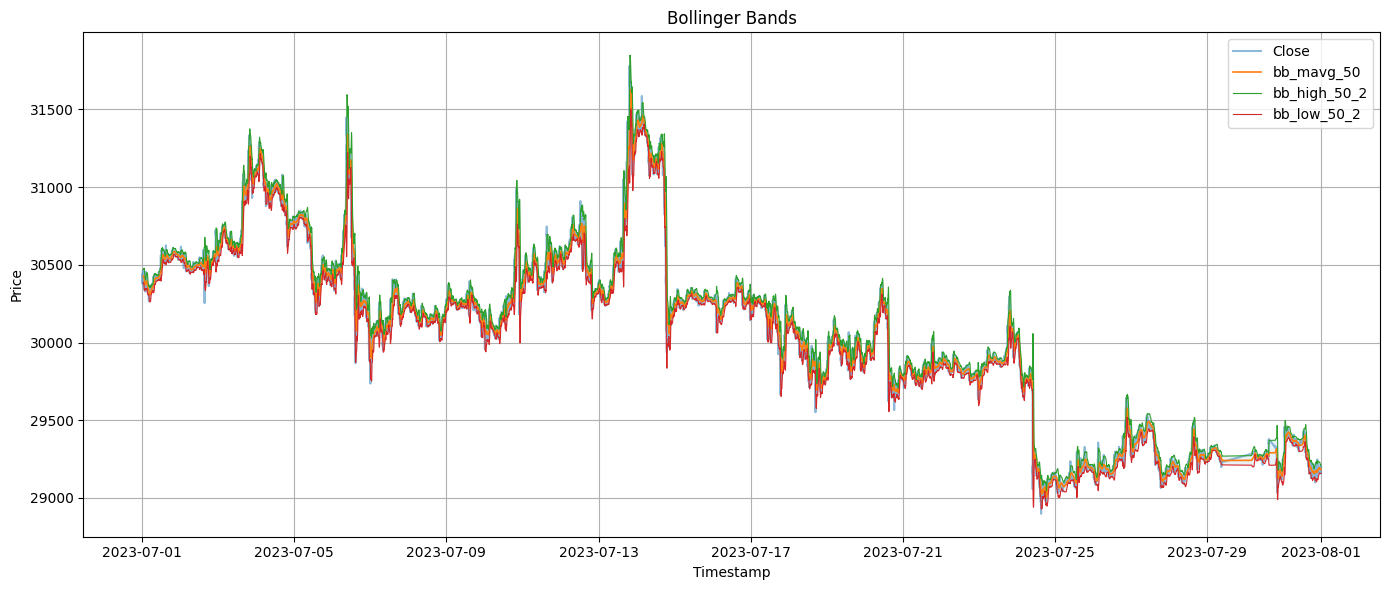

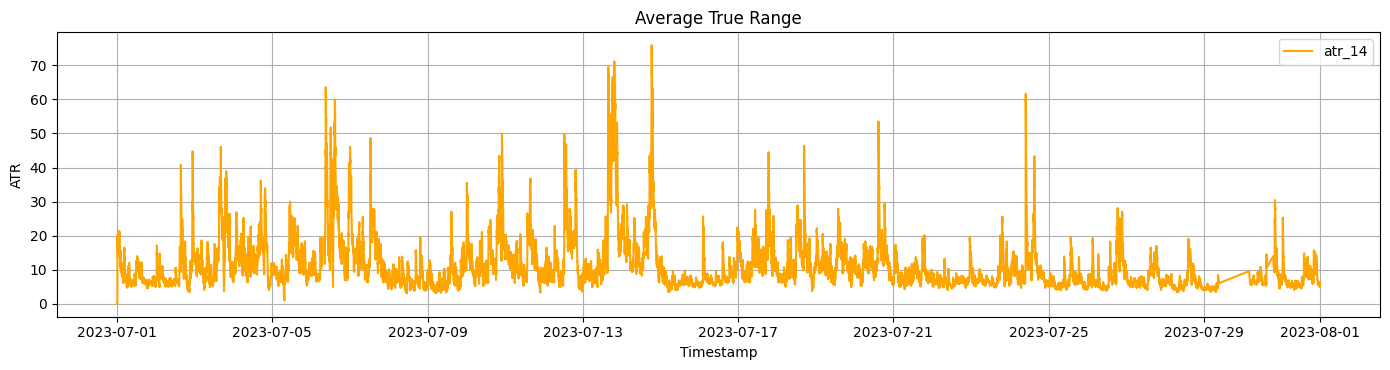

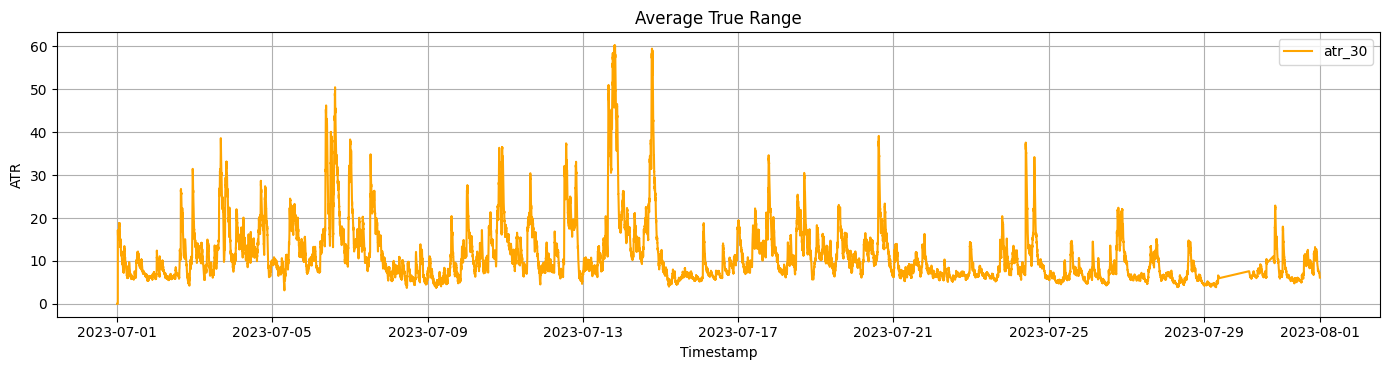

In [20]:
vip = VolatilityIndicatorPipeline(store_path=f"lmdb://{DB_PATH}")

df_vol = vip.run(
    df,
    symbol="BTC_sample_1month",         # Save in ArcticDB
    bb_params=[(20, 2), (50, 2)],       # ➜ 20×2σ  &  50×2σ Bollinger Bands
    atr_windows=[14, 30]                # ➜ 14 days ATR & 30 days ATR
)